In [ ]:
import glob
from pathlib import Path

from tqdm.auto import tqdm

from mlip_arena.models import REGISTRY
from mlip_arena.tasks.stability.input import get_atoms_from_db

RUN_DIR = Path(".").resolve()

In [ ]:
compositions = []
sizes = []
for atoms in tqdm(get_atoms_from_db("random-mixture.db")):
    if len(atoms) == 0:
        continue
    compositions.append(atoms.get_chemical_formula())

0it [00:00, ?it/s]

21:51:53.643 | INFO    | Task run 'get_atoms_from_db' - Finished in state Completed()

/tmp/ipykernel_2140436/3298160172.py:7: UserWarning: default value of fill_value changed from zero to None.
  pmv.count_elements(compositions[:1000]),
/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)


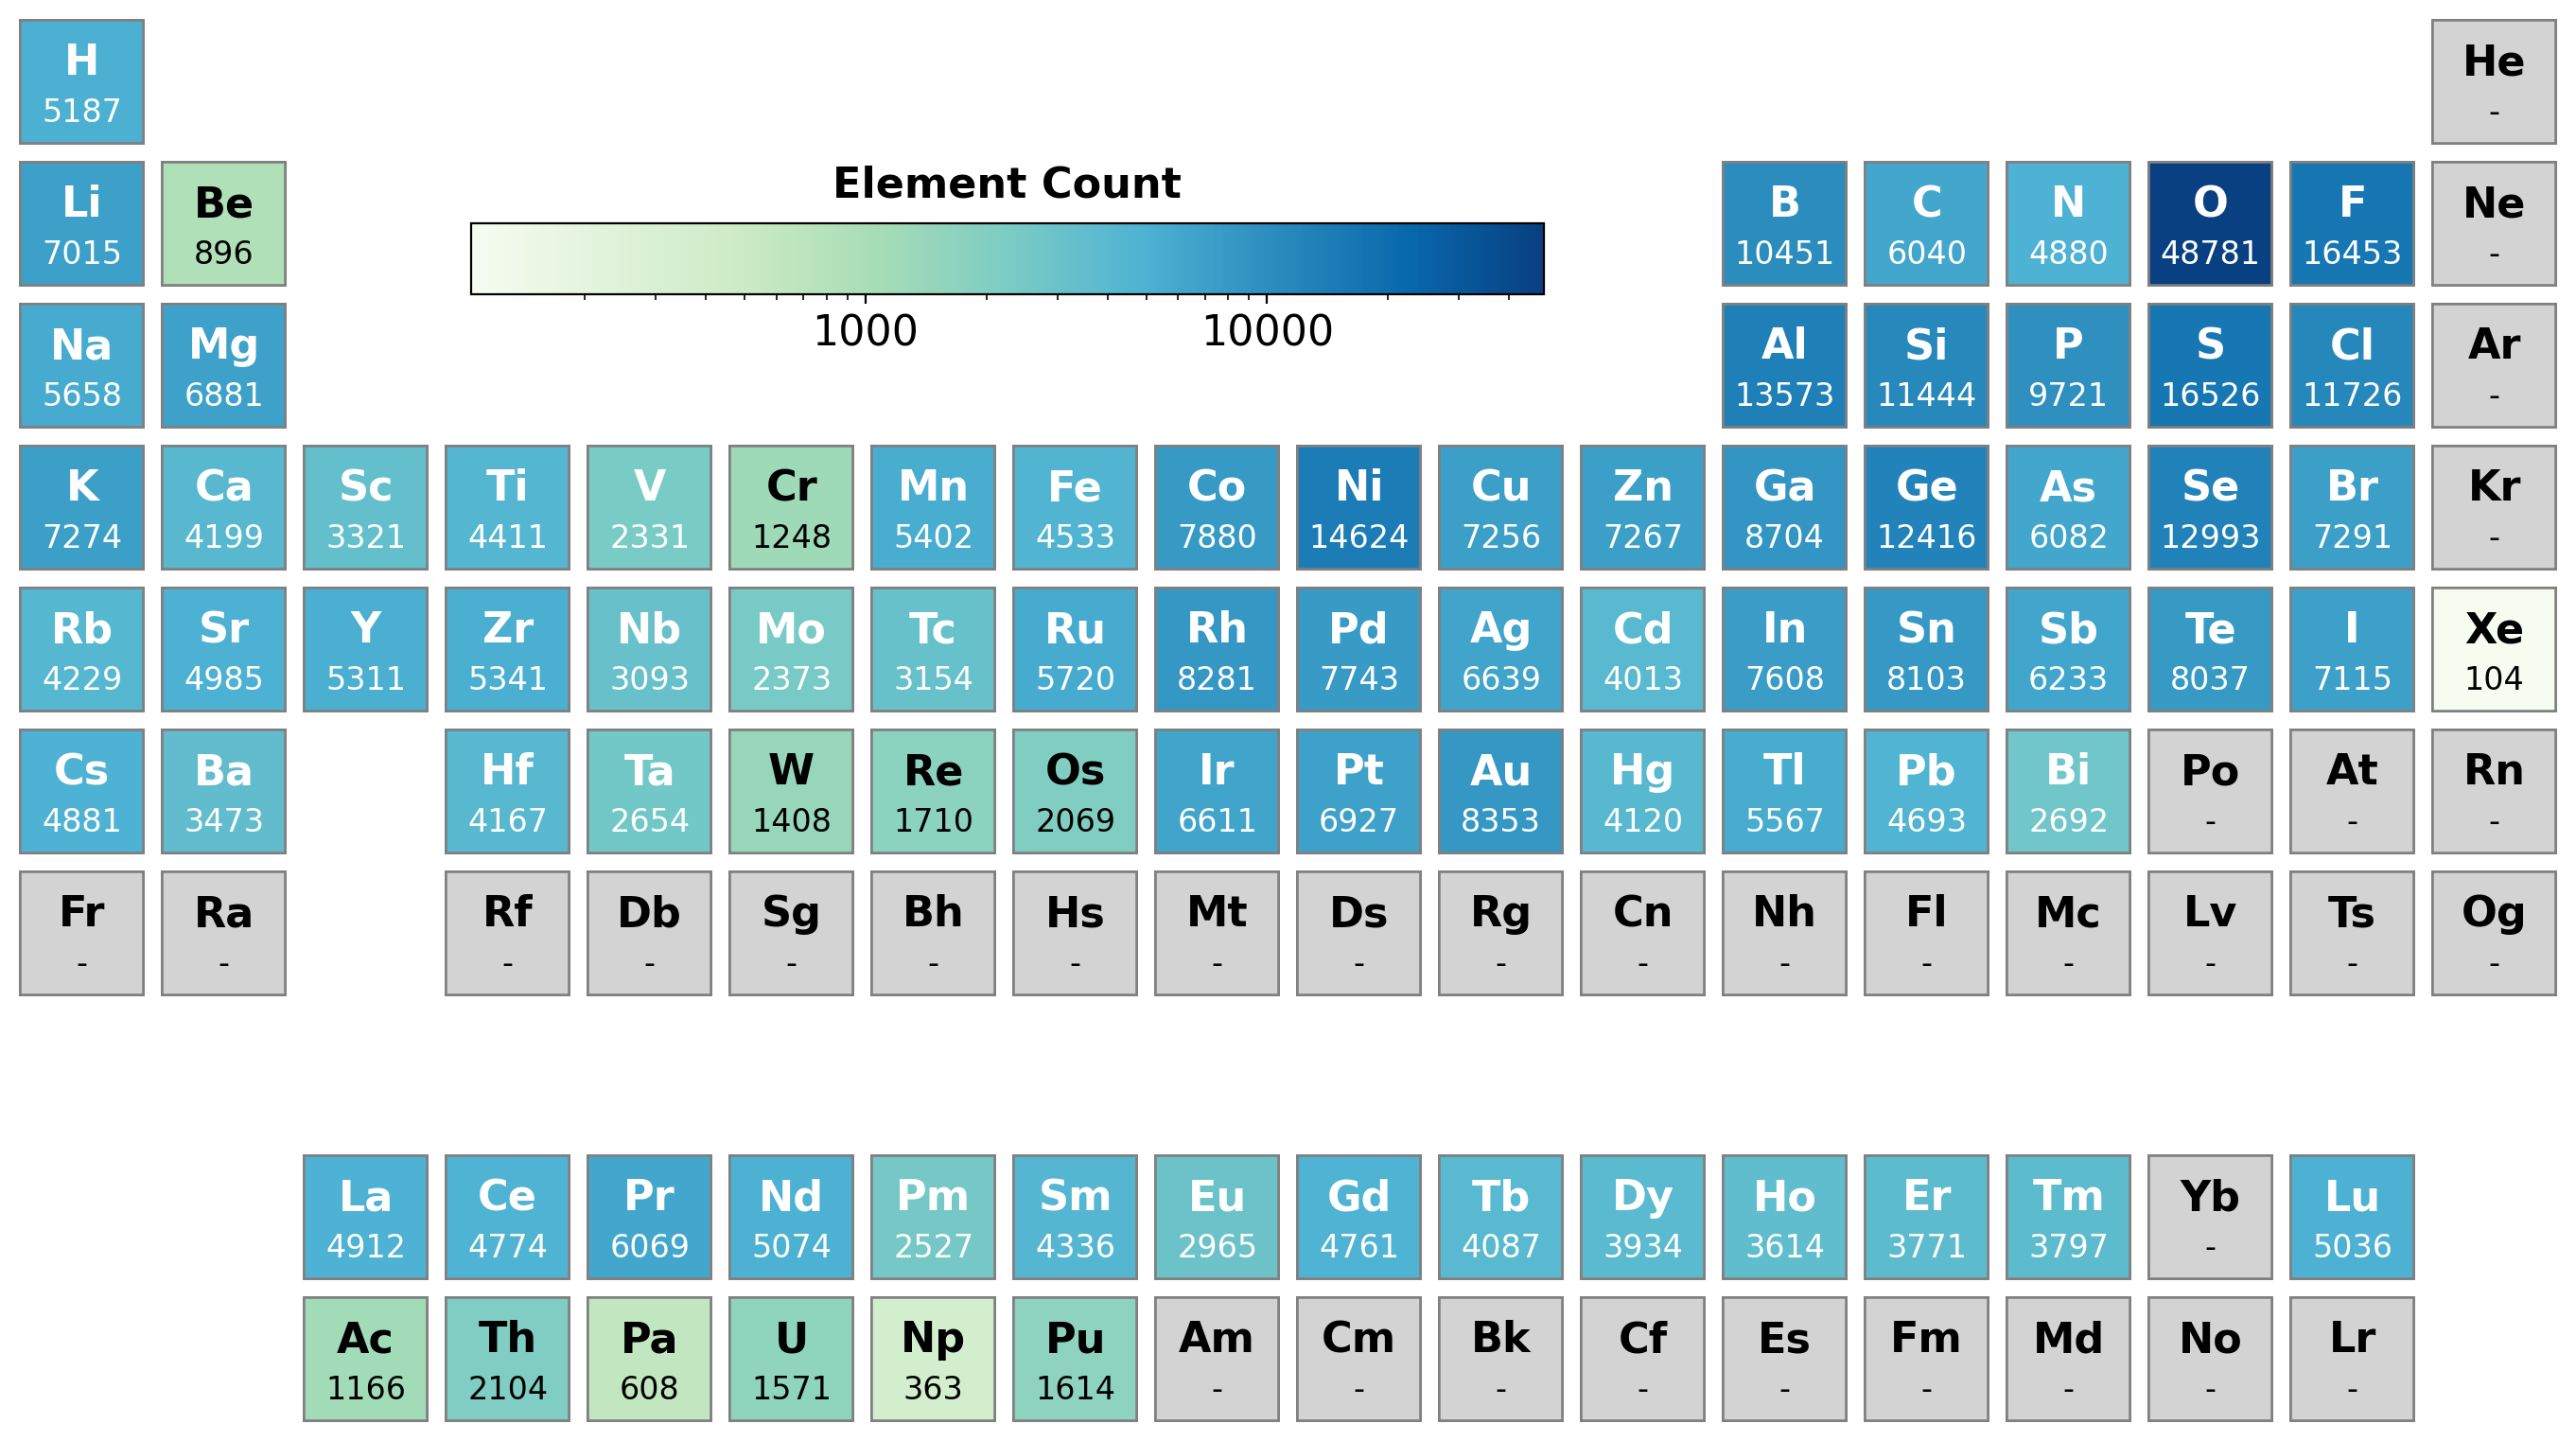

In [ ]:
import pymatviz as pmv
from matplotlib import pyplot as plt

%matplotlib inline

fig = pmv.ptable_heatmap(
    pmv.count_elements(compositions[:1000]),
    colormap="GnBu",
    log=True,
    return_type="figure",
)

plt.savefig("../figures/stability-element-counts.pdf")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from ase import Atoms


def get_runtime_stats(traj: list[Atoms], atoms0: Atoms):
    restarts = []
    steps, times = [], []
    Ts, Ps, Es, KEs = [], [], [], []
    timesteps = []
    com_drifts = []

    for atoms in tqdm(traj):
        assert isinstance(atoms, Atoms)
        try:
            energy = atoms.get_potential_energy()
            assert np.isfinite(energy), f"invalid energy: {energy}"
            # assert np.all(~np.isnan(atoms.get_forces())), f"invalid forces: {atoms.get_forces()}"
            # assert np.all(~np.isnan(atoms.get_stress())), f"invalid stress: {atoms.get_stress()}"
        except Exception:
            continue

        restarts.append(atoms.info["restart"])
        times.append(atoms.info["datetime"])
        steps.append(atoms.info["step"])
        Es.append(energy)
        KEs.append(atoms.get_kinetic_energy())
        Ts.append(atoms.get_temperature())
        try:
            Ps.append(atoms.get_stress()[:3].mean())
        except:
            pass
        com_drifts.append(
            (atoms.get_center_of_mass() - atoms0.get_center_of_mass()).tolist()
        )

    restarts = np.array(restarts)
    times = np.array(times)
    steps = np.array(steps)

    # Identify unique blocks
    unique_restarts = np.unique(restarts)

    total_time_seconds = 0
    total_steps = 0

    # Iterate over unique blocks to calculate averages
    for block in unique_restarts:
        # Get the indices corresponding to the current block
        # indices = np.where(restarts == block)[0]
        indices = restarts == block
        # Extract the corresponding data values
        block_time = times[indices][-1] - times[indices][0]
        total_time_seconds += block_time.total_seconds()
        total_steps += steps[indices][-1] - steps[indices][0]

    target_steps = traj[0].info["target_steps"]
    natoms = len(traj[0])

    return {
        "natoms": natoms,
        "total_time_seconds": total_time_seconds,
        "total_steps": total_steps,
        "steps_per_second": total_steps / total_time_seconds
        if total_time_seconds != 0
        else 0,
        "seconds_per_step": total_time_seconds / total_steps
        if total_steps != 0
        else float("inf"),
        "seconds_per_step_per_atom": total_time_seconds / total_steps / natoms
        if total_steps != 0
        else float("inf"),
        "energies": Es,
        "kinetic_energies": KEs,
        "temperatures": Ts,
        "pressures": Ps,
        "target_steps": target_steps,
        "final_step": steps[-1] if len(steps) != 0 else 0,
        "timestep": steps,
        "com_drifts": com_drifts,
    }


In [ ]:
import plotly.colors as pcolors

mlip_methods = [
    model
    for model, metadata in REGISTRY.items()
    if "stability" in metadata.get("gpu-tasks", [])
]

all_attributes = dir(pcolors.qualitative)
color_palettes = {
    attr: getattr(pcolors.qualitative, attr)
    for attr in all_attributes
    if isinstance(getattr(pcolors.qualitative, attr), list)
}
color_palettes.pop("__all__", None)

palette_names = list(color_palettes.keys())
palette_colors = list(color_palettes.values())
palette_name = "T10"  # "Plotly"
color_sequence = color_palettes[palette_name]  # type: ignore

method_color_mapping = {
    method: color_sequence[i % len(color_sequence)]
    for i, method in enumerate(mlip_methods)
}

# NPT

In [ ]:
# from huggingface_hub import HfApi
import seaborn as sns
from ase import units
from ase.io import read
from matplotlib import pyplot as plt

df = pd.DataFrame()

for model in mlip_methods:
    # if "stability" not in REGISTRY[model]['gpu-tasks']:
    #     continue

    files = glob.glob(str(RUN_DIR / REGISTRY[model]["family"] / f"{model}_*npt.traj"))

    for i, file in enumerate(files):
        try:
            traj = read(file, index=":")
        except Exception as e:
            print(f"Error reading {file}: {e}")
            continue

        try:
            stats = get_runtime_stats(traj, atoms0=traj[0])
        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    {
                        "model": model,
                        "formula": traj[0].get_chemical_formula(),
                        "normalized_timestep": stats["timestep"]
                        / stats["target_steps"],
                        "normalized_final_step": stats["final_step"]
                        / stats["target_steps"],
                        "pressure": np.array(stats["pressures"]) / units.GPa,
                    }
                    | stats
                ),
            ],
            ignore_index=True,
        )


CHGNet 76
M3GNet 23
MACE-MP(M) 70
MACE-MPA 70
MatterSim 71
ORBv2 73
SevenNet 63


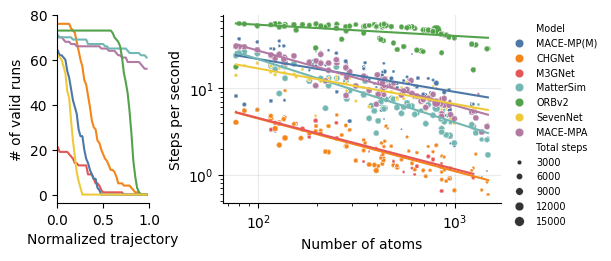

In [ ]:
%matplotlib inline

# import scipy.optimize as opt
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


# Define the power-law fitting function
def power_law(x, a, n):
    return a * np.power(x, n)


df.rename(
    columns={
        "final_step": "Total steps",
        "model": "Model",
    },
    inplace=True,
)

with plt.style.context("default"):
    fig, axes = plt.subplot_mosaic(
        """
        ao
        """,
        constrained_layout=True,
        figsize=(6, 2.5),
        width_ratios=[1, 3],
    )

    iax = "o"
    ax = axes.pop(iax)

    sns.scatterplot(
        data=df,
        x="natoms",
        y="steps_per_second",
        size="Total steps",
        hue="Model",
        ax=ax,
        palette=method_color_mapping,
        sizes=(1, 50),
        # alpha=0.5
    )

    # Fit and plot power-law regression for each model
    for model, data in df.groupby("Model"):
        data.dropna(subset=["steps_per_second"], inplace=True)

        popt, pcov = curve_fit(power_law, data["natoms"], data["steps_per_second"])

        # Generate smooth curve
        # x_fit = np.logspace(np.log10(xdata.min()), np.log10(xdata.max()), 100)
        # y_fit = power_law(x_fit, a_fit, n_fit)

        x = np.linspace(data["natoms"].min(), data["natoms"].max(), 100)

        # Plot regression line
        ax.plot(
            x,
            power_law(x, *popt),
            c=method_color_mapping[model],
            # label=f"{model} (y={a_fit:.2e}x^{n_fit:.2f})",
            linestyle="-",
        )

    # sns.lineplot(
    #     data=df,
    #     x='natoms',
    #     y='steps_per_second',
    #     # size='Total steps',
    #     hue='Model',
    #     ax=ax,
    #     palette=method_color_mapping,
    #     alpha=0.5,
    #     # err_style="bars"
    # )

    ax.set(
        xlabel="Number of atoms",
        xscale="log",
        ylabel="Steps per second",
        yscale="log",
    )
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.grid(alpha=0.25)
    ax.legend(
        loc="upper left", bbox_to_anchor=(1.0, 1.0), fontsize="x-small", frameon=False
    )

    # iax = 'a'

    for k, df_model in df.groupby("Model"):
        ax = axes["a"]

        df_model.drop_duplicates(["formula"], inplace=True)
        df_model = df_model[df_model["formula"].isin(compositions[:80])].copy()
        print(k, len(df_model))

        # Compute histogram
        bins = np.linspace(0, 1, 50)  # 50 bins from 0 to 1
        hist, bin_edges = np.histogram(
            df_model["normalized_final_step"], bins=bins, density=False
        )

        # Compute cumulative population
        cumulative_population = np.cumsum(hist)

        # Midpoints for binning
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        sns.lineplot(
            x=bin_centers[:-1],
            y=(cumulative_population[-1] - cumulative_population[:-1]),
            ax=axes["a"],
            # label=k,
            color=method_color_mapping[k],
            # palette=method_color_mapping
        )
        ylo, yhi = axes["a"].get_ylim()
        axes["a"].set(
            xlabel="Normalized trajectory",
            ylabel="# of valid runs",
            xlim=(0, 1),
            yticks=range(0, 81, 20),
            # title=k
        )

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        # ax.axline((0, 300), (1, 3000), c='k', lw=0.5, alpha=0.25)
        ax.legend_ = None

    plt.savefig("../figures/stability-and-speed-npt-loglog.pdf", bbox_inches="tight")
    plt.savefig(
        "../figures/stability-and-speed-npt-loglog.png", bbox_inches="tight", dpi=330
    )

    plt.show()

# NVT

In [ ]:
import pandas as pd

# from huggingface_hub import HfApi
import seaborn as sns
from ase import units
from ase.io import read
from matplotlib import pyplot as plt

df = pd.DataFrame()

for model in mlip_methods:
    # if "stability" not in REGISTRY[model]['gpu-tasks']:
    #     continue

    files = glob.glob(str(RUN_DIR / REGISTRY[model]["family"] / f"{model}_*nvt.traj"))

    for i, file in enumerate(files):
        try:
            traj = read(file, index=":")
        except Exception as e:
            print(f"Error reading {file}: {e}")
            continue

        try:
            stats = get_runtime_stats(traj, atoms0=traj[0])
        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue

        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    {
                        "model": model,
                        "formula": traj[0].get_chemical_formula(),
                        "normalized_timestep": stats["timestep"]
                        / stats["target_steps"],
                        "normalized_final_step": stats["final_step"]
                        / stats["target_steps"],
                        "pressure": np.array(stats["pressures"]) / units.GPa,
                    }
                    | stats
                ),
            ],
            ignore_index=True,
        )


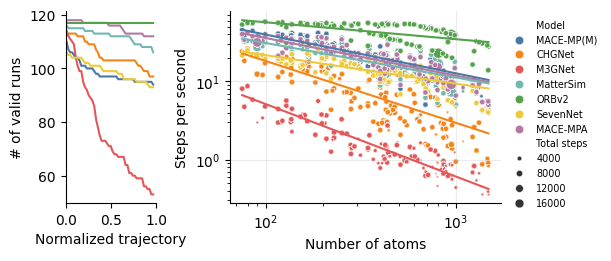

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# import scipy.optimize as opt
import seaborn as sns
from scipy.optimize import curve_fit


# Define the power-law fitting function
def power_law(x, a, n):
    return a * np.power(x, n)


df.rename(
    columns={
        "final_step": "Total steps",
        "model": "Model",
    },
    inplace=True,
)

with plt.style.context("default"):
    fig, axes = plt.subplot_mosaic(
        """
        ao
        """,
        constrained_layout=True,
        figsize=(6, 2.5),
        width_ratios=[1, 3],
    )

    iax = "o"
    ax = axes.pop(iax)

    sns.scatterplot(
        data=df,
        x="natoms",
        y="steps_per_second",
        size="Total steps",
        hue="Model",
        ax=ax,
        palette=method_color_mapping,
        sizes=(1, 50),
        # alpha=0.5
    )

    # Fit and plot power-law regression for each model
    for model, data in df.groupby("Model"):
        data.dropna(subset=["steps_per_second"], inplace=True)

        popt, pcov = curve_fit(power_law, data["natoms"], data["steps_per_second"])

        # Generate smooth curve
        # x_fit = np.logspace(np.log10(xdata.min()), np.log10(xdata.max()), 100)
        # y_fit = power_law(x_fit, a_fit, n_fit)

        x = np.linspace(data["natoms"].min(), data["natoms"].max(), 100)

        # Plot regression line
        ax.plot(
            x,
            power_law(x, *popt),
            c=method_color_mapping[model],
            # label=f"{model} (y={a_fit:.2e}x^{n_fit:.2f})",
            linestyle="-",
        )

    # sns.lineplot(
    #     data=df,
    #     x='natoms',
    #     y='steps_per_second',
    #     # size='Total steps',
    #     hue='Model',
    #     ax=ax,
    #     palette=method_color_mapping,
    #     alpha=0.5,
    #     # err_style="bars"
    # )

    ax.set(
        xlabel="Number of atoms",
        xscale="log",
        ylabel="Steps per second",
        yscale="log",
    )
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.grid(alpha=0.25)
    ax.legend(
        loc="upper left", bbox_to_anchor=(1.0, 1.0), fontsize="x-small", frameon=False
    )

    # iax = 'a'

    for k, df_model in df.groupby("Model"):
        ax = axes["a"]

        df_model.drop_duplicates(["formula"], inplace=True)
        df_model = df_model[df_model["formula"].isin(compositions[:120])].copy()

        # Compute histogram
        bins = np.linspace(0, 1, 50)  # 50 bins from 0 to 1
        hist, bin_edges = np.histogram(
            df_model["normalized_final_step"], bins=bins, density=False
        )

        # Compute cumulative population
        cumulative_population = np.cumsum(hist)

        # Midpoints for binning
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        sns.lineplot(
            x=bin_centers[:-1],
            y=(cumulative_population[-1] - cumulative_population[:-1]),
            ax=axes["a"],
            # label=k,
            color=method_color_mapping[k],
            # palette=method_color_mapping
        )

        axes["a"].set(
            xlabel="Normalized trajectory",
            ylabel="# of valid runs",
            xlim=(0, 1),
            # title=k
        )

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        # ax.axline((0, 300), (1, 3000), c='k', lw=0.5, alpha=0.25)
        ax.legend_ = None

    plt.savefig("../figures/stability-and-speed-nvt-loglog.pdf", bbox_inches="tight")
    plt.savefig(
        "../figures/stability-and-speed-nvt-loglog.png", bbox_inches="tight", dpi=330
    )

    plt.show()